#### Threshold based metrics

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prediction_utils.pytorch_utils.metrics import StandardEvaluator

In [2]:
clmbr_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/adapter_artifacts/'
clmbr_ete_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/clmbr_artifacts/'
base_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/baseline/artifacts'

thresholds = {
    'LOS_7':[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65],
    'icu_admission':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15],
}


encoders = {
    'count':'Counts',
    'gru':'GRU',
    'transformer':'Transf',
}

models = {
    'lr':'LR',
}

ete_models = {
    'gru':'GRU ETE',
    'transformer': 'Transf ETE'
}

tasks = {
    'LOS_7':'Long LOS',
    'icu_admission':'ICU Admission'
}

In [3]:
clmbr_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/adapter_artifacts/'
clmbr_ete_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/clmbr/clmbr_artifacts/'
base_path = '/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/experiments/baseline/artifacts'

thresholds = {
    'LOS_7':[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65],
    'icu_admission':[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15],
}


encoders = {
    'count':'Counts',
    'gru':'GRU',
    'transformer':'Transf',
}

models = {
    'lr':'LR',
}

ete_models = {
    'gru':'GRU ETE',
    'transformer': 'Transf ETE'
}

tasks = {
    'LOS_7':'Long LOS',
    'icu_admission':'ICU Admission'
}

df_all = pd.DataFrame()

for model in models:
    for c, encoder in enumerate(encoders):
        for r, task in enumerate(tasks):
            
            fpath = os.path.join(
                base_path 
                if encoder=='count' 
                else clmbr_path,
                task,
                'pred_probs',
                f"{model}_2009_2010_2011_2012" 
                if encoder=='count' 
                else f"{encoder}_{model}_2009_2010_2011_2012"
            )
            
            files = os.listdir(fpath)
            
            assert(len(files)==1)
            
            df = pd.read_csv(os.path.join(fpath,files[0]))
            df['test_group']= df['test_group'].astype(str)

            df = df.replace({
                '2009_2010_2011_2012':'09-12',
                '2013':'13-16',
                '2014':'13-16',
                '2015':'13-16',
                '2016':'13-16',
                '2017':'17-21',
                '2018':'17-21',
                '2019':'17-21',
                '2020':'17-21',
                '2021':'17-21',
            })
            
            df = df.query("test_group==['09-12','13-16','17-21']")
            
            df = df.assign(
                task=task,
                encoder=encoder,
                model=model
            )
            
            if encoder=='count':
                features_row_id_map = pd.read_parquet('/labs/shahlab/projects/lguo/temp_ds_shift_robustness/clmbr/features/admissions_admission_midnight/merged_features_binary/features_sparse/features_row_id_map.parquet')
                df = df.merge(features_row_id_map, how='left', left_on='features_row_id', right_on='features_row_id')
            
            df_all = pd.concat((df_all,df))
            

/labs/shahlab/envs/lguo/temp_ds_shift_robustness/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### How many decisions would have been changed?

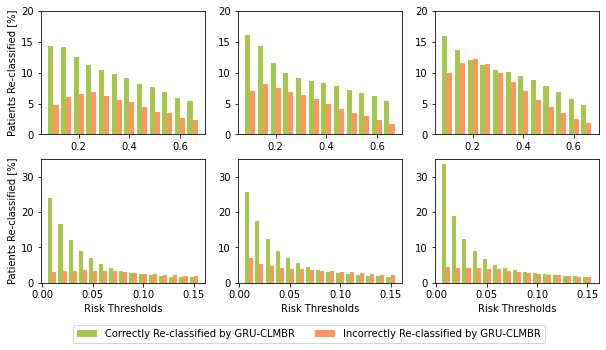

In [4]:
df_results = pd.DataFrame(columns=['threshold','task','test_group','prop_benefited','prop_costed','difference'])
c=0

for task in tasks:
    df = (
        df_all
        .query("task==@task and encoder==['count','gru'] and model=='lr'")
        [['prediction_id','pred_probs','labels','test_group','encoder']]
    )
    
    threshs = thresholds[task]
    for thresh in threshs:
        for group in df['test_group'].unique().tolist():

            data = df.query("test_group==@group").reset_index(drop=True)
            data['predictions']=data['pred_probs']>thresh
            data = (
                data
                .pivot_table(
                    index='prediction_id',
                    columns='encoder',
                    values='predictions'
                )
                .reset_index()
                .merge(
                    data[['prediction_id','labels']],
                    how='left',left_on='prediction_id',
                    right_on='prediction_id'
                )
            )

            c+=1

            benefited = len(data.query("count!=labels and gru==labels"))/len(data)*100
            costed = len(data.query("count==labels and gru!=labels"))/len(data)*100

            df_results.loc[c,:] = [
                thresh, 
                task,
                group, 
                round(benefited,1), 
                round(costed,1),
                round(benefited-costed,1),
            ]

groups = df_results['test_group'].unique()

fig,axes=plt.subplots(len(tasks),len(groups),figsize=(10,5))

for r, task in enumerate(tasks):
    for c,group in enumerate(groups):

        temp = df_results.query("test_group==@group and task==@task")
        
        if task =='LOS_7': 
            width = 0.02
            ylim = [0,20]
            x1 = temp['threshold'].values-0.01
            x2 = temp['threshold'].values+0.01
            
        elif task == 'icu_admission':
            width = 0.004
            ylim = [0,35]
            x1 = temp['threshold'].values-0.002
            x2 = temp['threshold'].values+0.002
            
        
        axes[r][c].bar(x1,temp['prop_benefited'],width,label='Correctly Re-classified by GRU-CLMBR',color='#a6c64c')
        axes[r][c].bar(x2,temp['prop_costed'],width,label='Incorrectly Re-classified by GRU-CLMBR',color='#ff955f')
        
        axes[r][c].set_ylim(ylim)
        
        if r==1:
            axes[r][c].set_xlabel('Risk Thresholds')
        
        if c==0: 
            axes[r][c].set_ylabel('Patients Re-classified [%]')
            
        if c==2 and r==1:
            axes[r][c].legend(
                bbox_to_anchor=(0.7, -0.3),
                ncol=2,
            )
            
#plt.savefig('figs/interpretation.png',dpi=300, bbox_inches='tight', pad_inches=0.5)